In [110]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.base import clone

from tqdm import tqdm

import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
import utils.ssvep_analysis as sa
from utils.transformer import WaveletTransformer
from utils.kernels import generalized_cone_kernel

In [111]:
def read_data(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    match = re.search(r'Subject:\s*(\S+)', content)
    subject = str(match.group(1))
    match = re.search(r'Series:\s*(\S+)', content)
    series = str(match.group(1))
    marker = df.to_numpy()[:, 0]
    start = np.argwhere(marker != 'grey')[0][0]
    end = np.argwhere(marker != 'grey')[-1][0]
    eeg_data = df.to_numpy()[start:end, 1:9].astype(float)
    return eeg_data, severity, subject, series

def build_dataset(directory_list):
    X = []
    y = []
    groups = []
    severities = []
    max_len = 0
    for directory in directory_list:
        for file in os.listdir('../data/' + directory):
            file_path = '../data/' + directory + '/' + file
            eeg_data, severity, subject, series = read_data(file_path)
            if series != 'multicolor-deuteranomaly-series' or eeg_data.shape[0] < 6000:
                continue
            X.append(eeg_data[250:-250])
            y.append(0 if severity == 0 else 1)
            groups.append(subject)
            severities.append(severity)
            max_len = max(max_len, X[-1].shape[0])
    return X, np.array(y), np.array(groups), np.array(severities), max_len


directory_list = ['2024-01-12', '2024-01-19', '2024-01-22', '2024-03-04-Gurke', '2024-03-04-Schroedi', '2024-03-08-Schwein', '2024-03-14-Daddy', '2024-03-23-Maracuja']

X, y, groups, severities, max_len = build_dataset(directory_list)

In [112]:
def preprocess_data(eeg_data, max_len):
    eeg_data = sa.remove_artefacts(eeg_data)
    eeg_data = sa.apply_ransac_detrending(eeg_data,)
    eeg_data = sa.apply_bandpass_filter(eeg_data, lowcut=14, highcut=35)
    eeg_data = sa.apply_notch_filter(eeg_data)
    eeg_data, _ = sa.compute_reduced_signal(eeg_data)
    eeg_data = np.concatenate((eeg_data, np.zeros(max_len - len(eeg_data))))
    return eeg_data

X = np.array([preprocess_data(x, max_len) for x in tqdm(X)])
X.shape

100%|██████████| 203/203 [00:30<00:00,  6.71it/s]


(203, 7273)

In [113]:
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.5, random_state=1)

pipeline = Pipeline([
    ('wavelet_transformer', WaveletTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=1)),
    ('svm', SVC(probability=True, random_state=1))
])

grid = {
    'wavelet_transformer__w_list': [[50]],
    'wavelet_transformer__n_samples': [50],
    'wavelet_transformer__n_frequencies': [20],
    'pca__n_components': [8],
    'svm__C': [1],
    'svm__gamma': ['scale'],
    'svm__kernel': ['linear']# , 'rbf', generalized_cone_kernel]
}

grid_search = GridSearchCV(pipeline, grid, cv=LeaveOneGroupOut(), scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train, groups=groups_train)
params = grid_search.best_params_
print('Best Params:', params)
print(f'Best Accuracy: {grid_search.best_score_:.2%}')

Best Params: {'pca__n_components': 8, 'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear', 'wavelet_transformer__n_frequencies': 20, 'wavelet_transformer__n_samples': 50, 'wavelet_transformer__w_list': [50]}
Best Accuracy: 91.71%


Accuracy: 86.27%
AUC ROC: 0.94


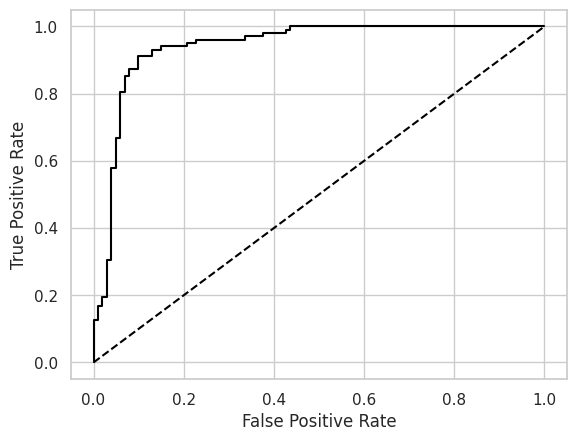

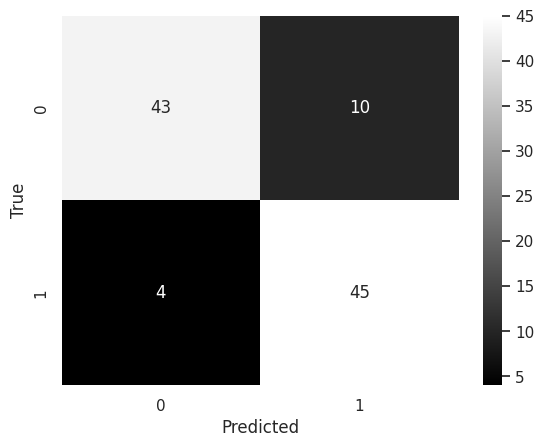

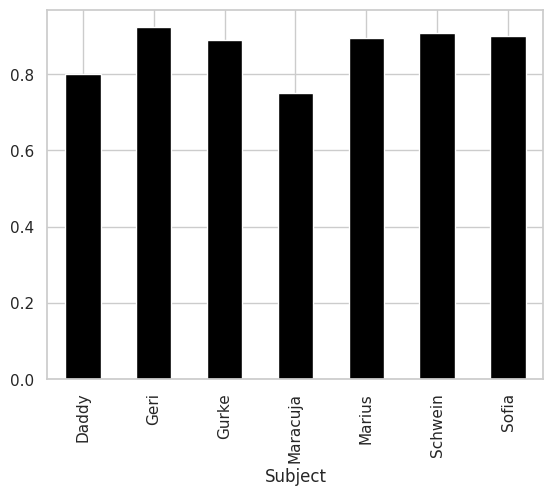

In [114]:
pipeline.set_params(**params)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:.2%}')

y_pred_proba = pipeline.predict_proba(X)
auc_roc = roc_auc_score(y, y_pred_proba[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

df = pd.DataFrame({'y': y_test, 'y_pred': y_pred, 'Subject': groups_test})
df['correct'] = df['y'] == df['y_pred']
df.groupby('Subject').mean()['correct'].plot(kind='bar', color='black');

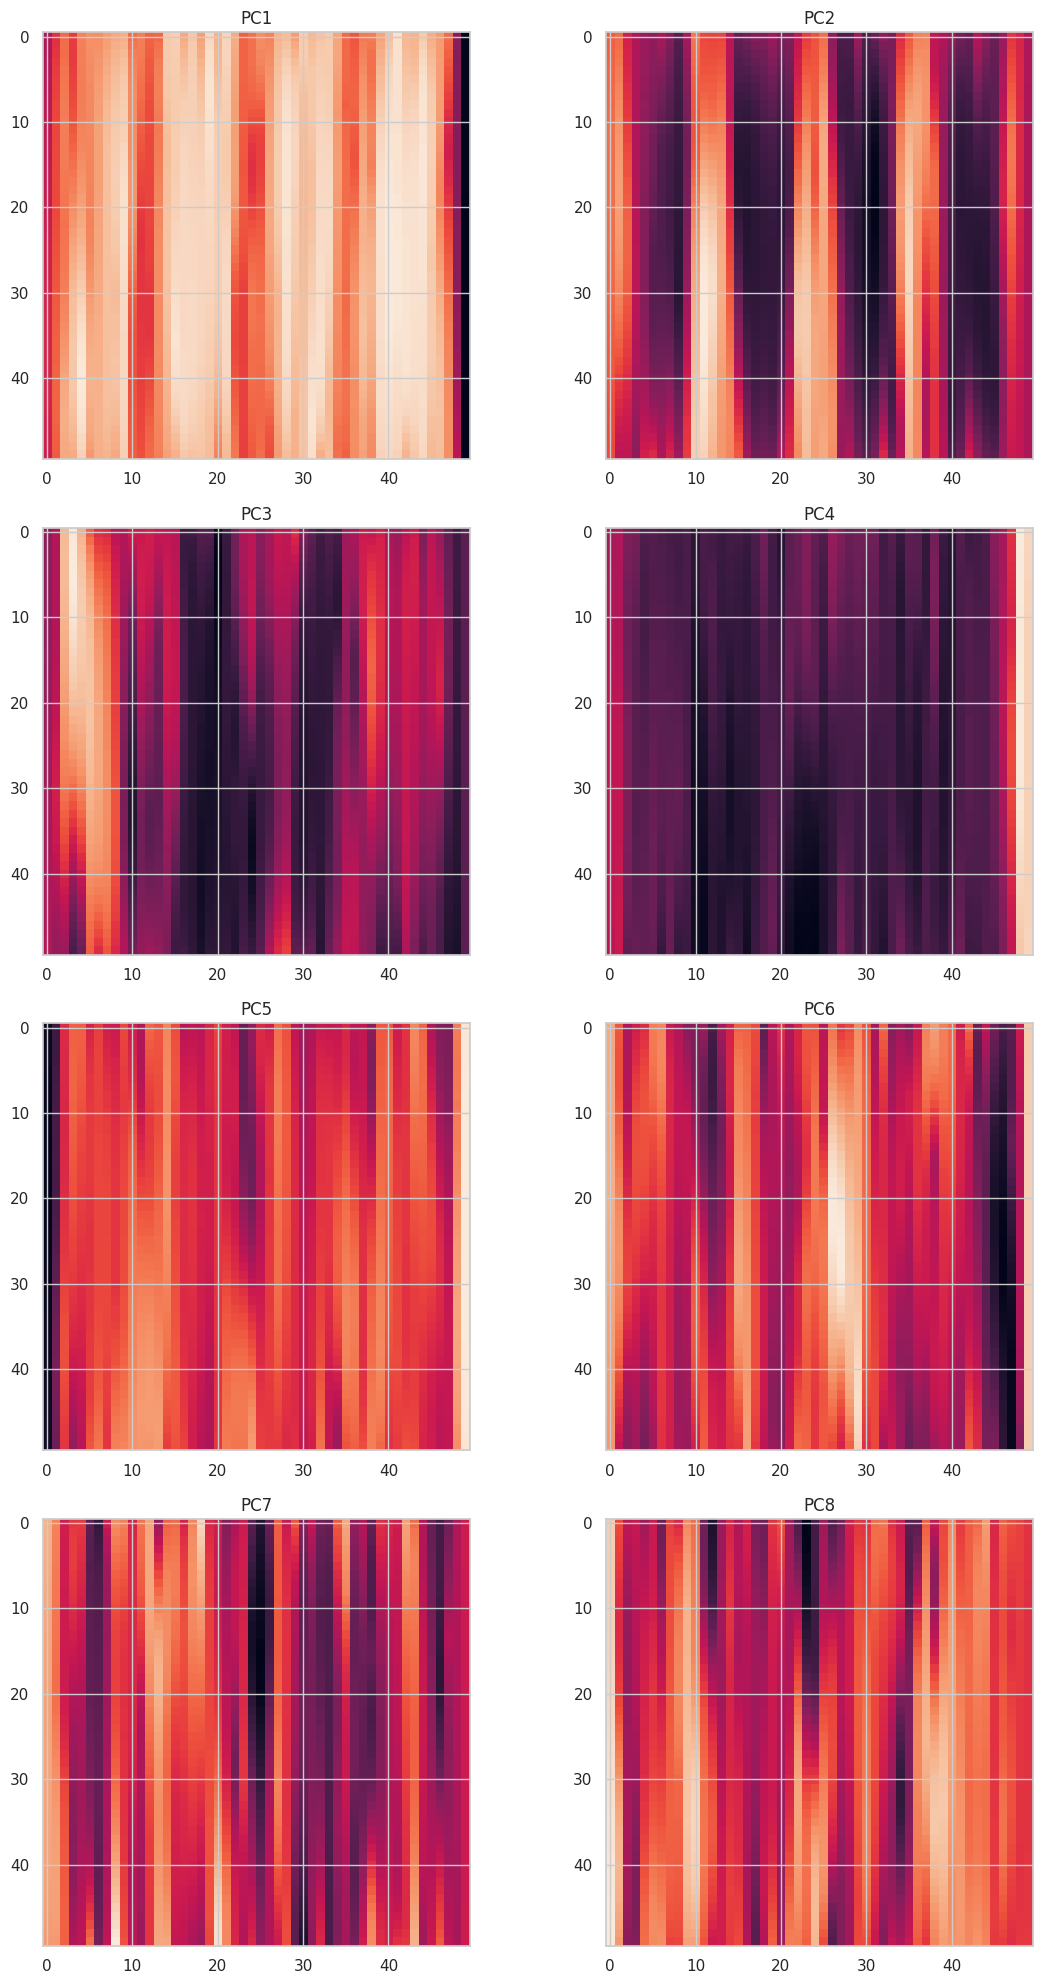

In [115]:
pca = pipeline.named_steps['pca']

num_plots = len(pca.components_)
num_cols = 2
num_rows = (num_plots + 1)//num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6*num_cols, 5*num_rows))

for row in range(num_rows):
    for col in range(num_cols):
        idx = row*num_cols + col
        if idx >= num_plots:
            break
        pc = pca.components_[idx]
        pc = np.moveaxis(pc.reshape(-1, 50, 50), 0, -1)
        pc = (pc - np.min(pc, axis=(0, 1))) / (np.max(pc, axis=(0, 1)) - np.min(pc, axis=(0, 1)))                             
        axes[row, col].imshow(pc[:,:,-1])
        axes[row, col].set_title('PC' + str(idx + 1))
fig.tight_layout()
plt.show()

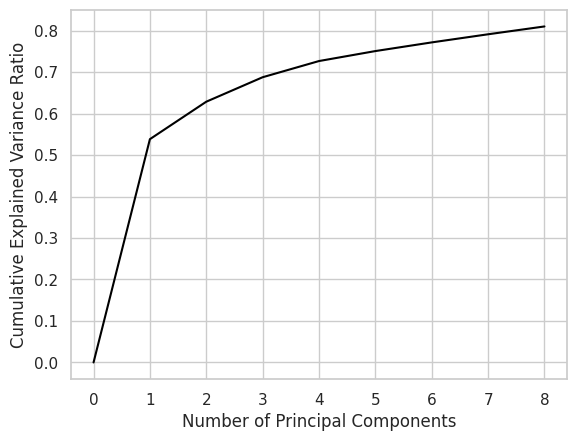

In [116]:
cumulative_explained_variance_ratio = np.concatenate((np.zeros(1), pca.explained_variance_ratio_)).cumsum()
num_components = len(cumulative_explained_variance_ratio)
plt.plot(range(0, num_components), cumulative_explained_variance_ratio, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

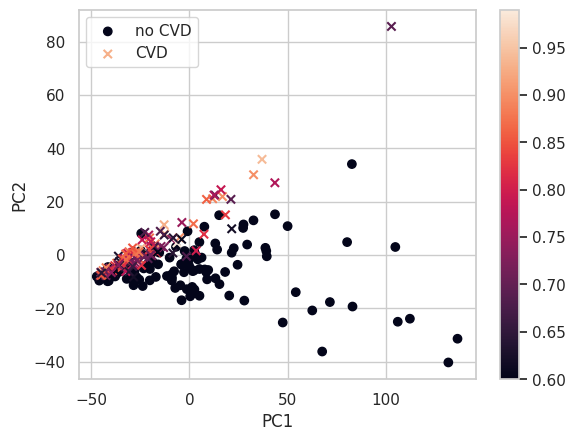

In [117]:
X_pca = pipeline.named_steps['wavelet_transformer'].transform(X)
X_pca = pipeline.named_steps['scaler'].transform(X_pca)
X_pca = pipeline.named_steps['pca'].transform(X_pca)

markers = ['o', 'x']
for i, marker in enumerate(markers):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], marker=marker, label='CVD' if i == 1 else 'no CVD', c=np.array(severities)[y == i])

plt.legend()
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Kernel: <function generalized_cone_kernel at 0x79f85032e480>


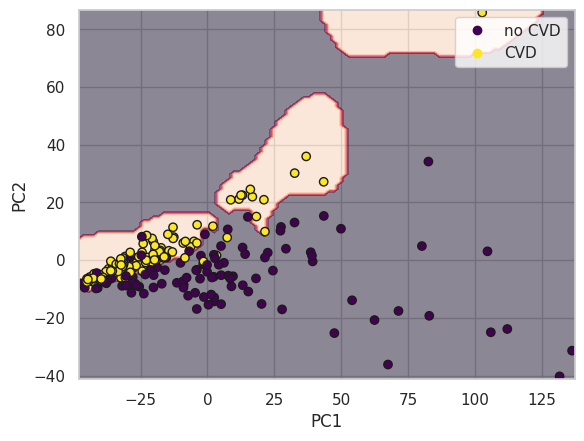

In [125]:
X_reduced = X_pca[:,:2]

model = clone(pipeline.named_steps['svm'])

for kernel in [generalized_cone_kernel]:
    model.kernel = kernel
    model.fit(X_reduced, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        model, X_reduced, response_method="predict",
        xlabel='PC1', ylabel='PC2',
        alpha=0.5,
    )
    scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', cmap='viridis')
    disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD'])
    print(f'Kernel: {kernel}')
    plt.show()

In [119]:
cvd_directory_list = ['2024-03-06-Jens', '2024-03-15-Wert', '2024-03-15-Fisch']
X_cvd, y_cvd, groups_cvd, severities_cvd, _ = build_dataset(cvd_directory_list)
X_cvd = np.array([preprocess_data(x, max_len) for x in tqdm(X_cvd)])

100%|██████████| 40/40 [00:05<00:00,  6.95it/s]


In [120]:
no_cvd_no_sim = pipeline.predict(X_test[y_test == 0])
no_cvd_sim = pipeline.predict(X_test[y_test == 1])
cvd_no_sim = pipeline.predict(X_cvd[y_cvd == 0])
cvd_sim = pipeline.predict(X_cvd[y_cvd == 1])

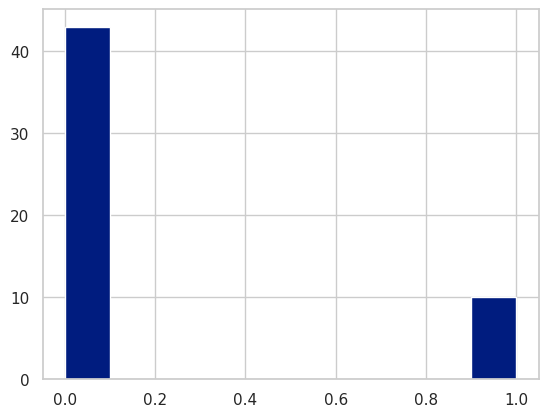

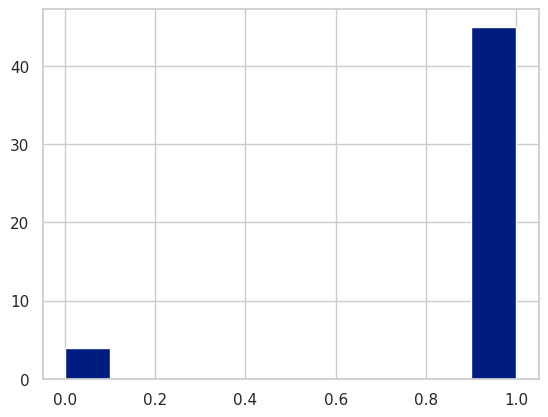

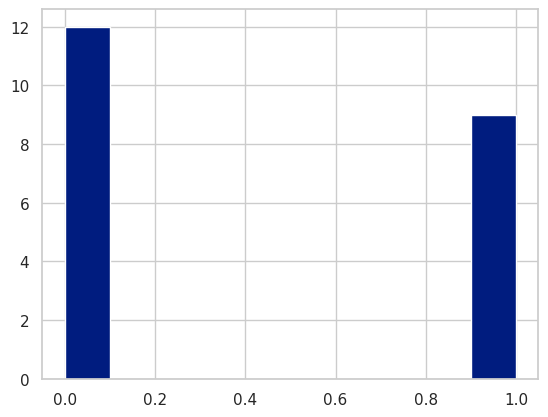

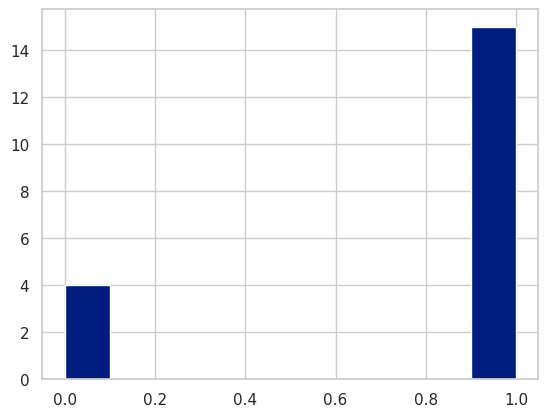

In [121]:
plt.hist(no_cvd_no_sim)
plt.show()
plt.hist(no_cvd_sim)
plt.show()
plt.hist(cvd_no_sim)
plt.show()
plt.hist(cvd_sim)
plt.show()

In [122]:
no_cvd_no_sim_pred= pipeline.predict_proba(X_test[y_test == 0])
no_cvd_sim_pred = pipeline.predict_proba(X_test[y_test == 1])
cvd_no_sim_pred = pipeline.predict_proba(X_cvd[y_cvd == 0])
cvd_sim_pred = pipeline.predict_proba(X_cvd[y_cvd == 1])

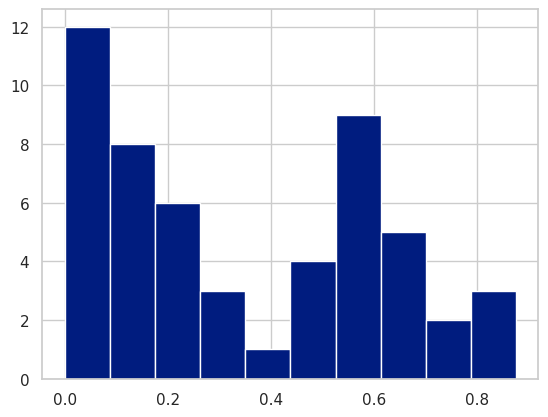

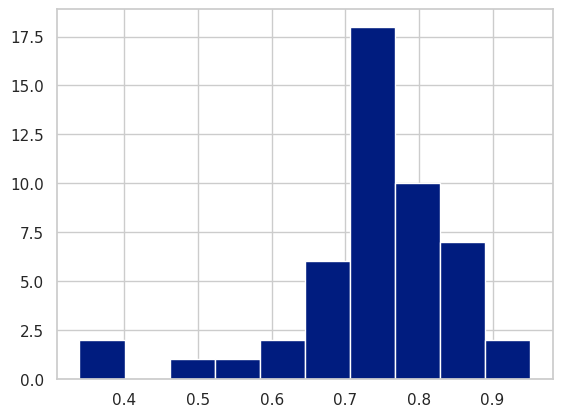

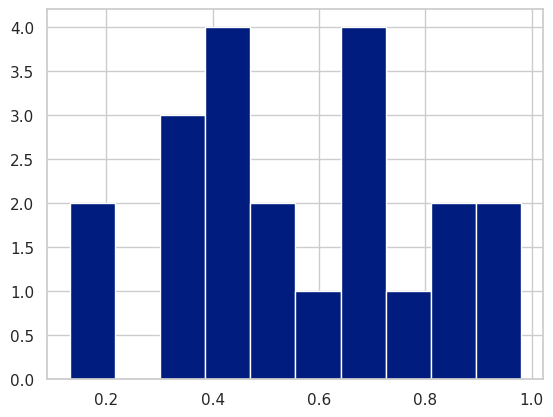

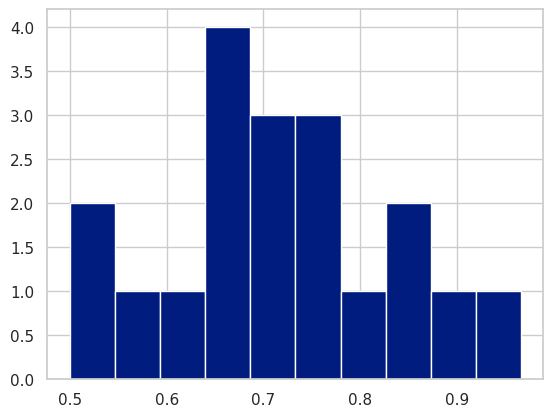

In [123]:
plt.hist(no_cvd_no_sim_pred[:, 1])
plt.show()
plt.hist(no_cvd_sim_pred[:, 1])
plt.show()
plt.hist(cvd_no_sim_pred[:, 1])
plt.show()
plt.hist(cvd_sim_pred[:, 1])
plt.show()

Subject: Schwein, Accuracy: 85.71%


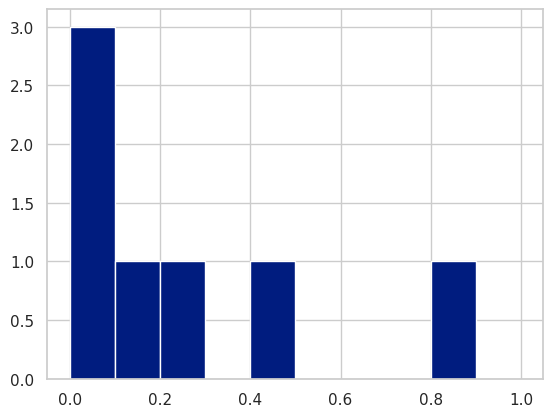

Subject: Daddy, Accuracy: 71.43%


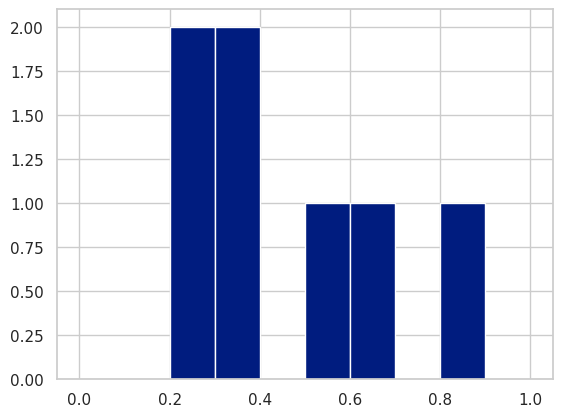

Subject: Geri, Accuracy: 100.00%


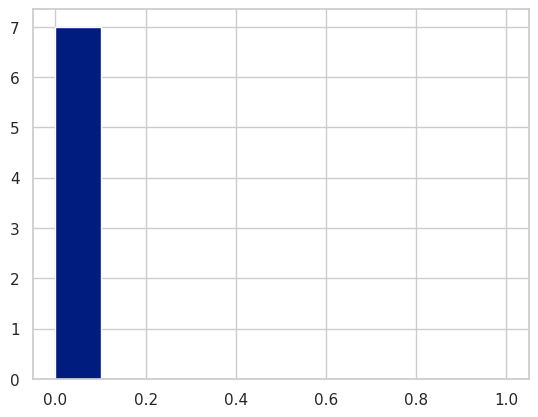

Subject: Maracuja, Accuracy: 63.64%


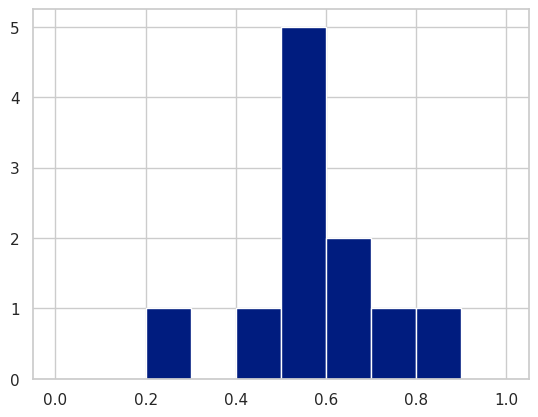

Subject: Gurke, Accuracy: 83.33%


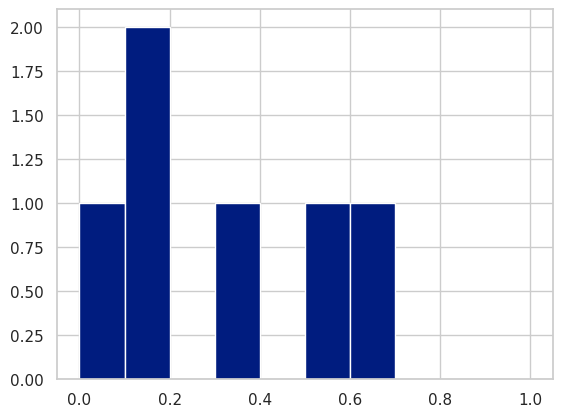

Subject: Sofia, Accuracy: 100.00%


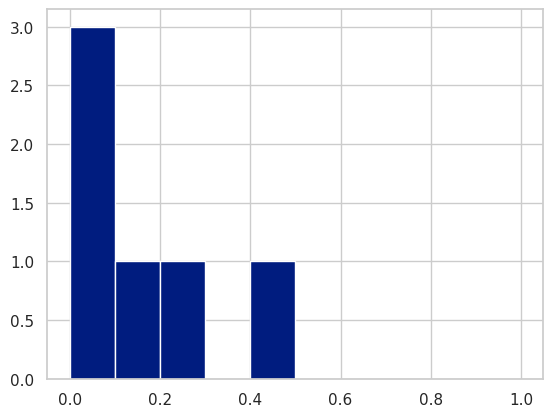

Subject: Marius, Accuracy: 77.78%


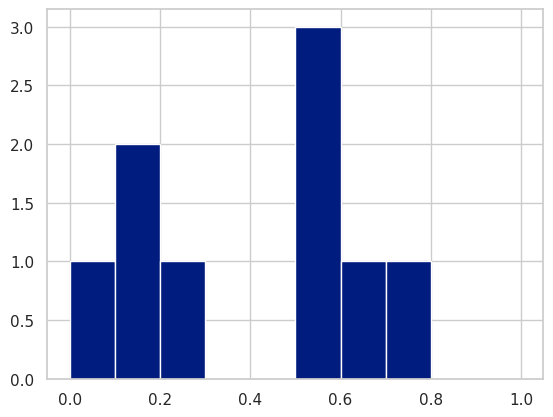

Subject: Wert, Accuracy: 50.00%


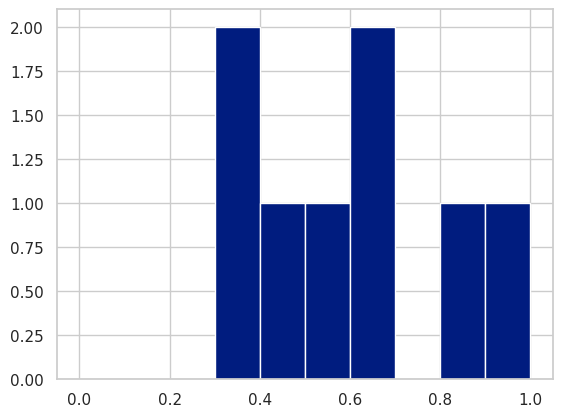

Subject: Jens, Accuracy: 61.54%


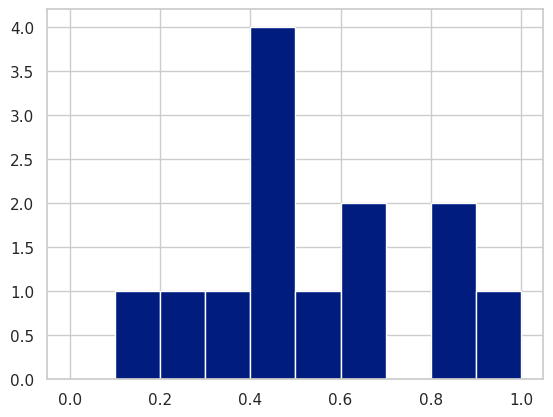

In [124]:
for group in set(groups_test):
    X_group = X_test[np.logical_and(groups_test == group, y_test == 0)]
    y_group = y_test[np.logical_and(groups_test == group, y_test == 0)]
    y_group_pred = pipeline.predict(X_group)
    y_group_pred_proba = pipeline.predict_proba(X_group)
    accuracy = np.mean(y_group == y_group_pred)
    print(f'Subject: {group}, Accuracy: {accuracy:.2%}')
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1))
    plt.show()

for group in set(groups_cvd):
    X_group = X_cvd[np.logical_and(groups_cvd == group, y_cvd == 0)]
    y_group = y_cvd[np.logical_and(groups_cvd == group, y_cvd == 0)]
    y_group_pred = pipeline.predict(X_group)
    y_group_pred_proba = pipeline.predict_proba(X_group)
    accuracy = np.mean(y_group == y_group_pred)
    print(f'Subject: {group}, Accuracy: {accuracy:.2%}')
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1))
    plt.show()